In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, precision_score,
                             recall_score, f1_score,fbeta_score)
from sklearn.model_selection import RandomizedSearchCV, cross_validate, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,roc_curve, confusion_matrix,brier_score_loss
from sklearn.preprocessing import RobustScaler
from datetime import date, timedelta
from datetime import datetime

In [2]:
users = pd.read_csv('./takehome_users.csv',encoding='latin-1')
user_eng = pd.read_csv('./takehome_user_engagement.csv')

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [5]:
user_eng['time_stamp'] = pd.to_datetime(user_eng['time_stamp'])
user_eng = user_eng.set_index('time_stamp')

In [6]:
user_eng['total_logins'] = user_eng['visited'].groupby(user_eng['user_id']).transform('sum')
user_eng = user_eng[user_eng['total_logins'] >=3]
user_eng

,user_id,visited,total_logins
time_stamp,,,
2013-11-15 03:45:04,2,1,14
2013-11-29 03:45:04,2,1,14
2013-12-09 03:45:04,2,1,14
2013-12-25 03:45:04,2,1,14
2013-12-31 03:45:04,2,1,14
...,...,...,...
2014-04-20 14:22:45,11991,1,5
2014-04-25 14:22:45,11991,1,5
2014-04-28 14:22:45,11991,1,5


In [7]:
user_count = pd.DataFrame(user_eng.groupby('user_id').resample('7D').visited.sum())

In [8]:
user_count = user_count.reset_index(level=0)

In [9]:
user_count = user_count[user_count['visited'] >= 3]
user_count = pd.DataFrame(user_count.user_id.drop_duplicates()).rename(columns={'user_id':'object_id'})

In [10]:
users['adopted_user'] = np.where(users.object_id.isin(user_count.object_id), 1, 0)

In [11]:
users.adopted_user.value_counts()

0    10528
1     1472
Name: adopted_user, dtype: int64

In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted_user                12000 non-null  int32  
dtypes: float64(2), int32(1), int64(4), object(4)
memory usage: 984.5+ KB


In [13]:
users.last_session_creation_time.fillna(0,inplace=True)

In [14]:
users['last_session_creation_time'] = users.last_session_creation_time.apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d')
                                                                             if x is not np.nan else np.nan)

In [15]:
users.last_session_creation_time.replace({'1969-12-31':np.nan},inplace=True)

In [16]:
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'])

In [17]:
users['activity_duration'] = (users['last_session_creation_time'] - users['creation_time']).dt.days
users['activity_duration'] = users['activity_duration'].mask(users['activity_duration'] < 0, 0)

In [18]:
users['activity_duration'] = users['activity_duration'].mask(users['activity_duration'] < 0, 0)

In [19]:
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,activity_duration
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-21,1,0,11,10803.0,0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-30,0,0,1,316.0,1,134.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19,0,0,94,1525.0,0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22,0,0,1,5151.0,0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22,0,0,193,5240.0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06,0,0,89,8263.0,0,0.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15,0,0,200,NaN,0,4.0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27,1,1,83,8074.0,0,0.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02,0,0,6,NaN,0,1.0


## I'm going to use XGBoost as it can handle missing values really well.

In [20]:
y = users[['adopted_user']]
X = users.drop(['adopted_user','last_session_creation_time','creation_time','object_id',
                'name','email','activity_duration'],axis=1) 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [23]:
X_train = pd.get_dummies(X_train, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8400, 8), (3600, 8), (8400,), (3600,))

In [24]:
cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=42)

In [25]:
xgb_parameters = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
               'max_depth' : [1,3,4,8,16],
               'min_child_weight' : [1,4,5,8,10],
               'colsample_bytree' : [0.6,0.8],
               'subsample' : [0.6,0.8,1.0],
               'n_estimators' : [200,400,800,1600,6400],
               'reg_alpha' : np.arange(0.001, 10, 1) }

In [26]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False)
xgb_clf = RandomizedSearchCV(xgb_model, param_distributions = xgb_parameters,cv=cv,scoring='roc_auc')

In [27]:
xgb_clf.fit(X_train,y_train)

[12:25:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:25:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:25:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:25:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[12:28:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:28:23] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:28:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:28:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None...
                   param_distributions={'colsample_bytree': [0.6, 0.8],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2, 0.3],
                                        'max_depth': [1, 3, 4, 8, 16],
                                        'min_child_weight': [1, 4, 5, 8, 10],
                                        'n_estimators': [200, 400, 800, 1600,
                                                         6400],
                                        'reg_alpha': array([1.000e-03, 1.001e+00, 2.001e+00, 3.001e+00, 4.001e+00, 5.001e+00,
       6.001e+00, 7.001e+00, 8.001e+00, 9.001e+00]),
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='roc_auc')

In [28]:
print('The best score is', xgb_clf.best_score_,'with following best parameters',xgb_clf.best_params_)

The best score is 0.5919755087492715 with following best parameters {'subsample': 1.0, 'reg_alpha': 9.000999999999998, 'n_estimators': 400, 'min_child_weight': 10, 'max_depth': 1, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [29]:
xgb_model = xgb.XGBClassifier(subsample=0.8, reg_alpha=8, 
                              n_estimators=200, min_child_weight=10, 
                              max_depth = 1, learning_rate = 0.1, colsample_bytree = 0.6,
                            seed=42, verbosity=0)

In [30]:
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=8, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=0)

In [31]:
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
xgb_preds = xgb_model.predict(X_test)

In [32]:
print(f'XGBoost Classifier\n')
roc = roc_auc_score(y_test, xgb_probs)
print(f'ROC AUC: {round(roc, 4)}')
print(classification_report(y_test, xgb_preds,zero_division=0))

XGBoost Classifier

ROC AUC: 0.6015
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      3151
           1       0.00      0.00      0.00       449

    accuracy                           0.88      3600
   macro avg       0.44      0.50      0.47      3600
weighted avg       0.77      0.88      0.82      3600



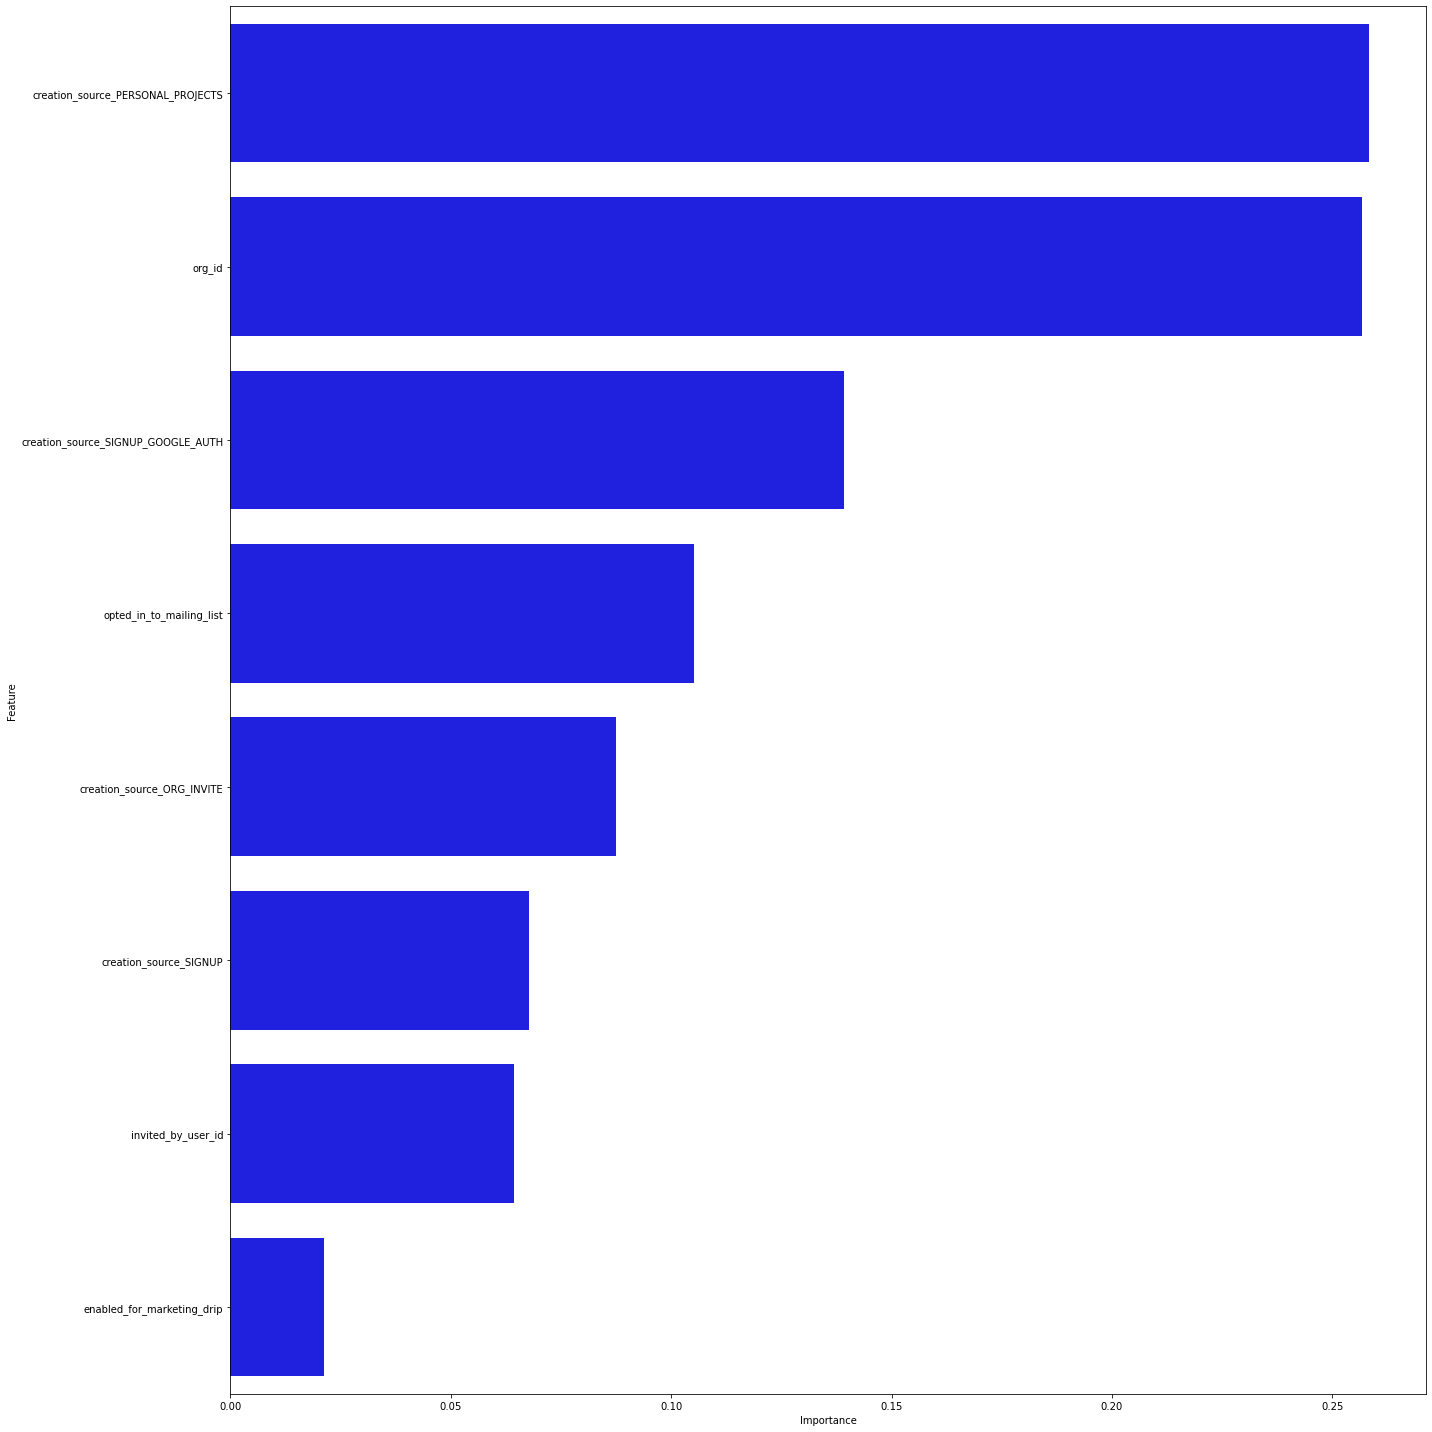

In [33]:
xgbfeatureimportance = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_model.feature_importances_}).sort_values('Importance', ascending = False)
plt.figure(figsize = (20,20))
ax = sns.barplot(x = 'Importance', y = 'Feature', data = xgbfeatureimportance, color = 'b')
plt.tight_layout()

## The most important features defining user adoption are:
## * 'creation_source' Some sources are more effective in bringing more active users than others, therefore I would recommend investing in an advertisement for various sources and platforms and product improvement to make the sign up process easier. 
## * 'org_id' - organization a user belongs to. Relax Inc. may need to optimize the product to encourage more organizations to use it. 
## * 'opted_in_to_mailing_list' - too intrusive and frequent marketing emails can discourage customers from using the product. Improving the quality of marketing emails can help retain more active users.